In [1]:
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import Audio,Image
from PIL import Image as PIL_Image
import multiprocessing
from joblib import Parallel,delayed
import gc, pickle

import os,sys
os.system("taskset -p 0xff %d" % os.getpid())
sys.path.append(os.path.expanduser('~')+'/audio_class/python')
sys.path.append('../../audio_class/python')
import audio_class
import ridgeDTW
import delay2loc
import audio_loc

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DATAROOT = './BBSPjun5_13/'

In [3]:
# load mics' locations
micsloc = []
with open('micloc1.csv','r') as fid:
    for lines in fid:
        tokens = lines.split(',')
        micsloc.append([float(tokens[0]),float(tokens[1]),float(tokens[2])])
micsloc = np.array(micsloc)
print('micsloc = %s' % micsloc)

micsloc = [[-39.624   -3.048    3.048 ]
 [-30.48     0.       3.048 ]
 [-21.336    0.       0.9144]
 [-12.192   -3.048    0.9144]
 [ -3.048   -3.048    3.048 ]
 [  6.096    0.       3.048 ]
 [ 15.24    -3.048    0.9144]
 [ 24.384    0.       0.9144]]


In [4]:
########## Work on a single recording first
fs,data = audio_class.readSegment(DATAROOT+'day2-1370485107.wav')
NCh,NDat = np.shape(data)

In [5]:
print('fs = %s' % fs)
print('NCh = %s, NDat = %s' % (NCh,NDat))
#Audio(data[0,:],rate=fs)

fs = 44100
NCh = 8, NDat = 2646000


In [21]:
# hierarchical processing
tHieBlk=[0.032,0.256]
tHieInc=[0.004,0.032]
hRidges,hSpecs = audio_loc.hieProc(data,fs,tHieBlk,tHieInc)

In [6]:
#with open('./hRidges_hSpecs.pkl','wb') as fid:
#    pickle.dump((hRidges,hSpecs),fid)
#with open('./hRidges_hSpecs.pkl','rb') as fid:
#    hRidges,hSpecs = pickle.load(fid)

True
n1 = 0, n2 = 1879


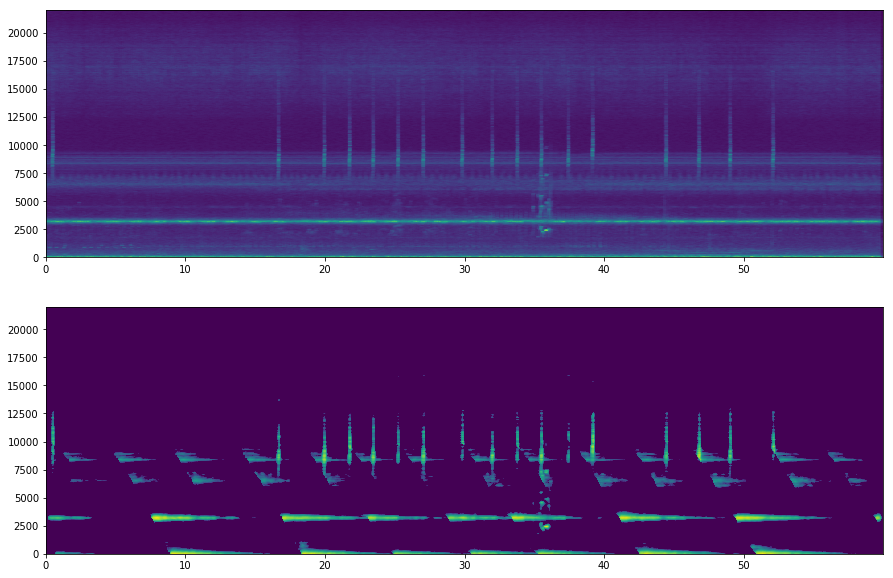

In [7]:
level = 1
chIdx = 7
S,F,T,tBlk,tInc = hSpecs[level][chIdx]
X = hRidges[level][chIdx]
print(tInc == T[1]-T[0])
n1 = int(0/tInc)
n2 = int(60/tInc)
print('n1 = %s, n2 = %s' % (n1,n2))

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.pcolormesh(T[n1:n2],F,np.sqrt(S[:,n1:n2]))
plt.subplot(212)
plt.pcolormesh(T[n1:n2],F,np.sqrt(X[:,n1:n2]))

In [ ]:
# per-channel cross-level processing
gc.collect()

tSegBlk = 2.
tSegInc = 1.
def xLevelProc(k,hRidges,hSpecs,tSegBlk,tSegInc):
    # per channel inputs
    Xh = hRidges[1][k]
    _,_,_,_,thInc = hSpecs[1][k]
    Xl = hRidges[0][k]
    _,_,_,_,tlInc = hSpecs[0][k]
    #print(thInc/tlInc)
    
    # Segmenting for causal/online processing 
    # and reduce computational load
    XhSegs,tSegBlk,tSegInc = audio_loc.segment(Xh,tSegBlk,tSegInc,thInc)
    #print('np.shape(XhSegs) = %s' % (np.shape(XhSegs),))
    lObjsAll = [None]*len(XhSegs)
    for l in range(30,40):#len(XhSegs)):
        # extract high-level objects
        hObjs = audio_loc.labelObjects(XhSegs[l])
        hObjs = audio_loc.pruneObj(hObjs)
        #print('np.shape(hObjs) = %s' % (np.shape(hObjs),))
        
        # extract low-level objects given high-level ones as masks
        n0,n1 = audio_loc.seg2bounds(l,tSegBlk,tSegInc,tlInc)
        XX = Xl[:,n0:n1]
        
        # debugging plots
        '''
        plt.figure()
        plt.subplot(211)
        plt.pcolormesh(XhSegs[l])
        plt.ylabel('XhSegs[l]')
        plt.subplot(212)
        plt.pcolormesh(XX)
        plt.ylabel('XX')
        '''
        
        lObjsGrp = [None]*len(hObjs)
        for i in range(len(hObjs)):
            # temporal upsampling with 
            # thInc: higher level time increment/scale
            # tlInc: lower level time increment/scale
            mask = np.repeat(hObjs[i],int(thInc/tlInc),axis=1)
            mask[mask > 0] = 1.
            '''
            print(np.shape(XX))
            print(np.shape(mask))
            plt.figure()
            plt.pcolormesh(mask)
            plt.ylabel('mask')
            '''
            lObjs = audio_loc.labelObjects(mask*np.pad(XX,((0,0),(0,mask.shape[1]-XX.shape[1])),'constant'))
            lObjs = audio_loc.pruneObj(lObjs)
            
            # all low-level objects belong to the same group
            lObjsGrp[i] = lObjs
        print('np.shape(lObjsGrp) = %s' % (np.shape(lObjsGrp),))
        '''
        plt.figure()
        plt.pcolormesh(lObjsGrp[0][0])
        '''
        
        lObjsAll[l] = lObjsGrp
        
    return lObjsAll
        
lObjsAllCh = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(xLevelProc)\
            (k,hRidges,hSpecs,tSegBlk,tSegInc) for k in range(NCh))
# swap channel and temporal segment index 
# to streamline subsequent multichannel processing
lObjsAllCh = np.swapaxes(lObjsAllCh,0,1)

print('np.shape(lObjsAllCh) = %s' % (np.shape(lObjsAllCh),))

In [7]:
#with open('./lObjsAllCh.pkl','wb') as fid:
#    pickle.dump(lObjsAllCh,fid)
#with open('./lObjsAllCh.pkl','rb') as fid:
#    lObjsAllCh = pickle.load(fid)

(61, 8)
(3,)
(6, 512, 682)


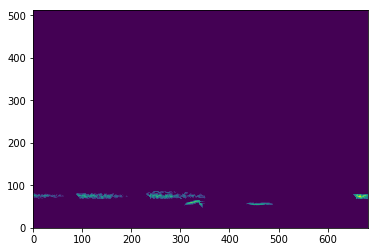

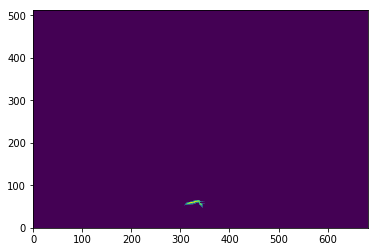

In [9]:
segIdx = 35 # audio segment/clip index
chIdx = 7 # channel index
grpIdx = 1 # group (of objects) index
objIdx = 0 # object index
print(np.shape(lObjsAllCh))
print(np.shape(lObjsAllCh[segIdx][chIdx])) # num of groups
print(np.shape(lObjsAllCh[segIdx][chIdx][grpIdx])) # num of objects

plt.figure()
plt.pcolormesh(np.mean(lObjsAllCh[segIdx][chIdx][grpIdx],axis=0))
plt.figure()
plt.pcolormesh(lObjsAllCh[segIdx][chIdx][grpIdx][objIdx])

In [15]:
# generates 3D images of our environment
# refs: TRTimage.py from mpop
def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h, 4 ) # quick reshape
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf
# refs: http://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector
def draw_ball(axes,cen,rad,color='r'):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = rad[0]*np.cos(u)*np.sin(v)
    y = rad[1]*np.sin(u)*np.sin(v)
    z = rad[2]*np.cos(v)
    axes.plot_wireframe(cen[0]+x,cen[1]+y,cen[2]+z,color=color)

In [78]:
# forming and working with groups
grps = np.zeros(np.shape(lObjsAllCh),dtype=object)
for segIdx in range(30,40):
    #print('==========')
    for chIdx in range(NCh):
        grps[segIdx,chIdx] = []
        for grpIdx in range(len(lObjsAllCh[segIdx,chIdx])):
            for objIdx in range(len(lObjsAllCh[segIdx,chIdx][grpIdx])):
                grps[segIdx,chIdx].append(lObjsAllCh[segIdx,chIdx][grpIdx][objIdx])
        grps[segIdx,chIdx] = np.array(grps[segIdx,chIdx])
        #print(np.shape(grps[segIdx,chIdx]))

[autoreload of delay2loc failed: Traceback (most recent call last):
  File "/home/blissbox/env3.6/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/blissbox/env3.6/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/blissbox/env3.6/lib/python3.6/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/blissbox/env3.6/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 608, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 205, in _call_with_frames_removed
  File "/home/blissbox/audio_loc/pyth

nIter = 1, mu = 1000.0, grad = [ 0.01290737 -0.02127064 -0.00086084], loc= [  1.45020202  11.80969114   3.5387536 ], err = 0.755620705964
nIter = 2, mu = 1000.0, grad = [-0.01010778 -0.00585961 -0.00032223], loc= [  0.          33.08033104   4.39959079], err = 0.463716390307
nIter = 3, mu = 500.0, grad = [ 0.01116416 -0.00889283 -0.00092724], loc= [  5.05389063  36.01013389   4.56070514], err = 0.449224027308
nIter = 4, mu = 500.0, grad = [-0.0080536  -0.00475215 -0.00030639], loc= [  0.          40.45654968   5.02432759], err = 0.424490834721
nIter = 5, mu = 500.0, grad = [ 0.00615403 -0.00618749 -0.00056522], loc= [  4.02679793  42.83262663   5.17752257], err = 0.389373503915
nIter = 6, mu = 250.0, grad = [-0.00773915 -0.0037526  -0.00021921], loc= [  2.48829018  44.37949924   5.3188265 ], err = 0.388129801604
nIter = 7, mu = 250.0, grad = [ 0.00604095 -0.00509289 -0.00054289], loc= [  4.42307782  45.31764906   5.37362936], err = 0.376793780001
nIter = 8, mu = 125.0, grad = [-0.00761

nIter = 207, mu = 62.5, grad = [ -3.56050462e-05  -1.54016821e-03  -3.78055837e-04], loc= [  8.15759297  73.94837964  10.43641969], err = 0.296824531996
nIter = 208, mu = 62.5, grad = [ -3.55670120e-05  -1.53739357e-03  -3.78011933e-04], loc= [  8.15981828  74.04464015  10.46004818], err = 0.296667001762
nIter = 209, mu = 62.5, grad = [ -3.55290672e-05  -1.53462972e-03  -3.77967717e-04], loc= [  8.16204122  74.14072725  10.48367392], err = 0.296510013243
nIter = 210, mu = 62.5, grad = [ -3.54912045e-05  -1.53187659e-03  -3.77923194e-04], loc= [  8.16426179  74.23664161  10.50729691], err = 0.296353563376
nIter = 211, mu = 62.5, grad = [ -3.54534292e-05  -1.52913412e-03  -3.77878369e-04], loc= [  8.16647999  74.33238389  10.53091711], err = 0.29619764912
nIter = 212, mu = 62.5, grad = [ -3.54157376e-05  -1.52640225e-03  -3.77833246e-04], loc= [  8.16869583  74.42795478  10.5545345 ], err = 0.296042267459
nIter = 213, mu = 62.5, grad = [ -3.53781324e-05  -1.52368092e-03  -3.77787829e-04]

nIter = 1, mu = 1000.0, grad = [ 0.01969676 -0.0244283  -0.0011305 ], loc= [  3.00353384  11.80969114   3.5387536 ], err = 0.884754547116
nIter = 2, mu = 1000.0, grad = [-0.00729347 -0.00705662 -0.00064661], loc= [  0.          36.23798951   4.66925001], err = 0.51495066133
nIter = 3, mu = 1000.0, grad = [ 0.00968922 -0.00818602 -0.0003699 ], loc= [  7.29347149  43.29461233   5.31585899], err = 0.481661661588
nIter = 4, mu = 1000.0, grad = [-0.0087191  -0.00305891 -0.00019891], loc= [  0.          51.48063294   5.6857574 ], err = 0.438613811378
nIter = 5, mu = 1000.0, grad = [ 0.00664873 -0.00550131 -0.00023254], loc= [  8.71909679  54.53953872   5.88466711], err = 0.416204346718
nIter = 6, mu = 1000.0, grad = [-0.00754652 -0.00218668 -0.00013086], loc= [  2.07036652  60.0408528    6.11720391], err = 0.399523703039
nIter = 7, mu = 1000.0, grad = [ 0.00636529 -0.00464039 -0.00019415], loc= [  9.61688426  62.22752966   6.24805906], err = 0.383094141065
nIter = 8, mu = 1000.0, grad = [-0.

nIter = 232, mu = 31.25, grad = [ -1.97975533e-04  -9.03028585e-04  -2.79746504e-05], loc= [  16.02232738  102.7513094     6.83104563], err = 0.294570361783
nIter = 233, mu = 31.25, grad = [ -1.97877468e-04  -9.02573490e-04  -2.79596448e-05], loc= [  16.02851412  102.77952904    6.83191984], err = 0.294538991385
nIter = 234, mu = 31.25, grad = [ -1.97779523e-04  -9.02118961e-04  -2.79446597e-05], loc= [  16.03469779  102.80773446    6.83279358], err = 0.294507652468
nIter = 235, mu = 31.25, grad = [ -1.97681698e-04  -9.01664996e-04  -2.79296951e-05], loc= [  16.0408784   102.83592568    6.83366685], err = 0.294476344977
nIter = 236, mu = 31.25, grad = [ -1.97583993e-04  -9.01211594e-04  -2.79147509e-05], loc= [  16.04705595  102.86410271    6.83453965], err = 0.294445068857
nIter = 237, mu = 31.25, grad = [ -1.97486407e-04  -9.00758755e-04  -2.78998272e-05], loc= [  16.05323045  102.89226557    6.83541199], err = 0.294413824054
nIter = 238, mu = 31.25, grad = [ -1.97388941e-04  -9.0030

nIter = 468, mu = 31.25, grad = [ -1.77725352e-04  -8.09220496e-04  -2.49219464e-05], loc= [  17.40471742  109.05109202    7.02559157], err = 0.287936213029
nIter = 469, mu = 31.25, grad = [ -1.77650275e-04  -8.08873327e-04  -2.49108023e-05], loc= [  17.41027133  109.07638016    7.02637038], err = 0.287910998933
nIter = 470, mu = 31.25, grad = [ -1.77575276e-04  -8.08526526e-04  -2.48996712e-05], loc= [  17.4158229   109.10165746    7.02714885], err = 0.287885806378
nIter = 471, mu = 31.25, grad = [ -1.77500356e-04  -8.08180093e-04  -2.48885531e-05], loc= [  17.42137213  109.12692391    7.02792696], err = 0.287860635331
nIter = 472, mu = 31.25, grad = [ -1.77425514e-04  -8.07834025e-04  -2.48774478e-05], loc= [  17.42691902  109.15217954    7.02870473], err = 0.28783548576
nIter = 473, mu = 31.25, grad = [ -1.77350750e-04  -8.07488323e-04  -2.48663555e-05], loc= [  17.43246356  109.17742435    7.02948215], err = 0.287810357635
nIter = 474, mu = 31.25, grad = [ -1.77276065e-04  -8.07142

nIter = 696, mu = 31.25, grad = [ -1.62413676e-04  -7.38510850e-04  -2.26763584e-05], loc= [  18.61467325  114.55650948    7.1948655 ], err = 0.282689098763
nIter = 697, mu = 31.25, grad = [ -1.62353617e-04  -7.38233865e-04  -2.26676590e-05], loc= [  18.61974867  114.57958794    7.19557414], err = 0.282668082607
nIter = 698, mu = 31.25, grad = [ -1.62293613e-04  -7.37957136e-04  -2.26589684e-05], loc= [  18.62482222  114.60265775    7.1962825 ], err = 0.282647082148
nIter = 699, mu = 31.25, grad = [ -1.62233663e-04  -7.37680663e-04  -2.26502866e-05], loc= [  18.6298939   114.62571891    7.1969906 ], err = 0.282626097364
nIter = 700, mu = 31.25, grad = [ -1.62173769e-04  -7.37404446e-04  -2.26416136e-05], loc= [  18.6349637   114.64877143    7.19769842], err = 0.282605128235
nIter = 701, mu = 31.25, grad = [ -1.62113929e-04  -7.37128485e-04  -2.26329494e-05], loc= [  18.64003163  114.67181532    7.19840597], err = 0.28258417474
nIter = 702, mu = 31.25, grad = [ -1.62054144e-04  -7.36852

nIter = 932, mu = 31.25, grad = [ -7.15364942e-05  -6.86529123e-04  -2.15042609e-05], loc= [  19.25462127  119.80221446    7.35728372], err = 0.278472420521
nIter = 933, mu = 31.25, grad = [ -7.15166647e-05  -6.86332816e-04  -2.15001942e-05], loc= [  19.25685678  119.82366849    7.35795573], err = 0.278456084572
nIter = 934, mu = 31.25, grad = [ -7.14968486e-05  -6.86136645e-04  -2.14961300e-05], loc= [  19.25909168  119.84511639    7.35862761], err = 0.278439758092
nIter = 935, mu = 31.25, grad = [ -7.14770456e-05  -6.85940610e-04  -2.14920683e-05], loc= [  19.26132596  119.86655816    7.35929937], err = 0.27842344107
nIter = 936, mu = 31.25, grad = [ -7.14572559e-05  -6.85744709e-04  -2.14880091e-05], loc= [  19.26355961  119.88799381    7.35997099], err = 0.278407133498
nIter = 937, mu = 31.25, grad = [ -7.14374795e-05  -6.85548943e-04  -2.14839524e-05], loc= [  19.26579265  119.90942333    7.36064249], err = 0.278390835367
nIter = 938, mu = 31.25, grad = [ -7.14177162e-05  -6.85353

nIter = 1169, mu = 31.25, grad = [ -6.71795790e-05  -6.43495596e-04  -2.06054927e-05], loc= [  19.76796408  124.72398104    7.51315768], err = 0.274846658898
nIter = 1170, mu = 31.25, grad = [ -6.71625426e-05  -6.43327710e-04  -2.06019579e-05], loc= [  19.77006344  124.74409028    7.51380161], err = 0.274832331343
nIter = 1171, mu = 31.25, grad = [ -6.71455167e-05  -6.43159930e-04  -2.05984252e-05], loc= [  19.77216227  124.76419427    7.51444542], err = 0.27481801136
nIter = 1172, mu = 31.25, grad = [ -6.71285012e-05  -6.42992256e-04  -2.05948945e-05], loc= [  19.77426056  124.78429302    7.51508912], err = 0.27480369894
nIter = 1173, mu = 31.25, grad = [ -6.71114961e-05  -6.42824688e-04  -2.05913657e-05], loc= [  19.77635833  124.80438653    7.51573271], err = 0.274789394078
nIter = 1174, mu = 31.25, grad = [ -6.70945015e-05  -6.42657225e-04  -2.05878390e-05], loc= [  19.77845556  124.8244748     7.51637619], err = 0.274775096767
nIter = 1175, mu = 31.25, grad = [ -6.70775173e-05  -6

nIter = 1407, mu = 31.25, grad = [ -6.22342805e-05  -5.23205058e-04  -1.09134710e-04], loc= [  20.2520182   129.28911117    7.70617433], err = 0.271694918108
nIter = 1408, mu = 31.25, grad = [ -6.22181649e-05  -5.23088494e-04  -1.09137975e-04], loc= [  20.25396302  129.30546133    7.70958479], err = 0.271684075385
nIter = 1409, mu = 31.25, grad = [ -6.22031699e-05  -5.22971992e-04  -1.09141237e-04], loc= [  20.25590734  129.32180785    7.71299535], err = 0.27167323735
nIter = 1410, mu = 31.25, grad = [ -6.21886121e-05  -5.22855551e-04  -1.09144496e-04], loc= [  20.25785119  129.33815072    7.71640601], err = 0.271662403964
nIter = 1411, mu = 31.25, grad = [ -6.21742276e-05  -5.22739171e-04  -1.09147751e-04], loc= [  20.25979458  129.35448996    7.71981678], err = 0.27165157521
nIter = 1412, mu = 31.25, grad = [ -6.21599148e-05  -5.22622850e-04  -1.09151004e-04], loc= [  20.26173753  129.37082556    7.72322764], err = 0.27164075108
nIter = 1413, mu = 31.25, grad = [ -6.21456341e-05  -5.

nIter = 1649, mu = 31.25, grad = [ -5.30242080e-05  -4.97022728e-04  -1.09878159e-04], loc= [  20.68038941  133.14475103    8.53435784], err = 0.269225880479
nIter = 1650, mu = 31.25, grad = [ -5.30142186e-05  -4.96921638e-04  -1.09880983e-04], loc= [  20.68204642  133.16028299    8.53779153], err = 0.269216228851
nIter = 1651, mu = 31.25, grad = [ -5.30042338e-05  -4.96820595e-04  -1.09883805e-04], loc= [  20.68370311  133.17581179    8.54122531], err = 0.269206580939
nIter = 1652, mu = 31.25, grad = [ -5.29942537e-05  -4.96719600e-04  -1.09886624e-04], loc= [  20.68535949  133.19133743    8.54465918], err = 0.269196936741
nIter = 1653, mu = 31.25, grad = [ -5.29842782e-05  -4.96618651e-04  -1.09889441e-04], loc= [  20.68701556  133.20685992    8.54809314], err = 0.269187296256
nIter = 1654, mu = 31.25, grad = [ -5.29743074e-05  -4.96517749e-04  -1.09892255e-04], loc= [  20.68867132  133.22237925    8.55152718], err = 0.269177659479
nIter = 1655, mu = 31.25, grad = [ -5.29643412e-05  

nIter = 1887, mu = 31.25, grad = [ -5.07709611e-05  -4.74218639e-04  -1.10482530e-04], loc= [  21.0662625   136.75539232    9.353896  ], err = 0.26702837385
nIter = 1888, mu = 31.25, grad = [ -5.07619916e-05  -4.74127849e-04  -1.10484803e-04], loc= [  21.06784909  136.77021165    9.35734858], err = 0.267019541346
nIter = 1889, mu = 31.25, grad = [ -5.07530260e-05  -4.74037099e-04  -1.10487074e-04], loc= [  21.0694354   136.78502815    9.36080123], err = 0.267010712027
nIter = 1890, mu = 31.25, grad = [ -5.07440643e-05  -4.73946389e-04  -1.10489343e-04], loc= [  21.07102144  136.79984181    9.36425395], err = 0.267001885889
nIter = 1891, mu = 31.25, grad = [ -5.07351066e-05  -4.73855718e-04  -1.10491610e-04], loc= [  21.07260719  136.81465263    9.36770674], err = 0.266993062931
nIter = 1892, mu = 31.25, grad = [ -5.07261528e-05  -4.73765087e-04  -1.10493875e-04], loc= [  21.07419266  136.82946063    9.37115961], err = 0.26698424315
nIter = 1893, mu = 31.25, grad = [ -5.07172029e-05  -4

nIter = 2127, mu = 31.25, grad = [ -4.87254458e-05  -4.53508865e-04  -1.10972998e-04], loc= [  21.43927498  140.23337471   10.18441319], err = 0.26499554629
nIter = 2128, mu = 31.25, grad = [ -4.87173498e-05  -4.53426873e-04  -1.10974827e-04], loc= [  21.44079765  140.24754687   10.1878811 ], err = 0.264987424146
nIter = 2129, mu = 31.25, grad = [ -4.87092572e-05  -4.53344915e-04  -1.10976654e-04], loc= [  21.44232007  140.26171646   10.19134906], err = 0.264979304751
nIter = 2130, mu = 31.25, grad = [ -4.87011680e-05  -4.53262991e-04  -1.10978479e-04], loc= [  21.44384224  140.27588348   10.19481708], err = 0.264971188104
nIter = 2131, mu = 31.25, grad = [ -4.86930821e-05  -4.53181100e-04  -1.10980303e-04], loc= [  21.44536415  140.29004795   10.19828516], err = 0.264963074202
nIter = 2132, mu = 31.25, grad = [ -4.86849996e-05  -4.53099243e-04  -1.10982125e-04], loc= [  21.44688581  140.30420986   10.20175329], err = 0.264954963044
nIter = 2133, mu = 31.25, grad = [ -4.86769204e-05  -

nIter = 2366, mu = 31.25, grad = [ -4.68814216e-05  -4.34826583e-04  -1.11366057e-04], loc= [  21.79622486  143.54993068   11.01475756], err = 0.263129047418
nIter = 2367, mu = 31.25, grad = [ -4.68740709e-05  -4.34752079e-04  -1.11367528e-04], loc= [  21.79768991  143.56351901   11.01823775], err = 0.263121538791
nIter = 2368, mu = 31.25, grad = [ -4.68667230e-05  -4.34677604e-04  -1.11368998e-04], loc= [  21.79915472  143.57710502   11.02171798], err = 0.263114032559
nIter = 2369, mu = 31.25, grad = [ -4.68593781e-05  -4.34603159e-04  -1.11370467e-04], loc= [  21.80061931  143.59068869   11.02519826], err = 0.26310652872
nIter = 2370, mu = 31.25, grad = [ -4.68520360e-05  -4.34528742e-04  -1.11371935e-04], loc= [  21.80208366  143.60427004   11.02867859], err = 0.263099027274
nIter = 2371, mu = 31.25, grad = [ -4.68446968e-05  -4.34454354e-04  -1.11373401e-04], loc= [  21.80354779  143.61784906   11.03215896], err = 0.263091528219
nIter = 2372, mu = 31.25, grad = [ -4.68373605e-05  -

nIter = 2607, mu = 31.25, grad = [ -4.51896177e-05  -4.17670905e-04  -1.11684317e-04], loc= [  22.1428582   146.75940073   11.85472097], err = 0.261385774618
nIter = 2608, mu = 31.25, grad = [ -4.51829158e-05  -4.17602907e-04  -1.11685495e-04], loc= [  22.14427037  146.77245294   11.85821111], err = 0.261378806638
nIter = 2609, mu = 31.25, grad = [ -4.51762163e-05  -4.17534934e-04  -1.11686672e-04], loc= [  22.14568234  146.78550303   11.86170128], err = 0.261371840758
nIter = 2610, mu = 31.25, grad = [ -4.51695193e-05  -4.17466987e-04  -1.11687848e-04], loc= [  22.14709409  146.798551     11.86519149], err = 0.261364876976
nIter = 2611, mu = 31.25, grad = [ -4.51628248e-05  -4.17399064e-04  -1.11689023e-04], loc= [  22.14850564  146.81159684   11.86868174], err = 0.261357915292
nIter = 2612, mu = 31.25, grad = [ -4.51561329e-05  -4.17331167e-04  -1.11690197e-04], loc= [  22.14991698  146.82464057   11.87217202], err = 0.261350955704
nIter = 2613, mu = 31.25, grad = [ -4.51494434e-05  

nIter = 2852, mu = 31.25, grad = [ -4.36191096e-05  -4.01727259e-04  -1.11942247e-04], loc= [  22.48276416  149.89551253   12.71082552], err = 0.259738794834
nIter = 2853, mu = 31.25, grad = [ -4.36129802e-05  -4.01664994e-04  -1.11943182e-04], loc= [  22.48412726  149.90806651   12.71432371], err = 0.259732309842
nIter = 2854, mu = 31.25, grad = [ -4.36068529e-05  -4.01602750e-04  -1.11944115e-04], loc= [  22.48549016  149.92061854   12.71782194], err = 0.2597258267
nIter = 2855, mu = 31.25, grad = [ -4.36007279e-05  -4.01540529e-04  -1.11945047e-04], loc= [  22.48685288  149.93316862   12.72132019], err = 0.259719345407
nIter = 2856, mu = 31.25, grad = [ -4.35946050e-05  -4.01478329e-04  -1.11945979e-04], loc= [  22.4882154   149.94571676   12.72481847], err = 0.259712865961
nIter = 2857, mu = 31.25, grad = [ -4.35884843e-05  -4.01416151e-04  -1.11946910e-04], loc= [  22.48957773  149.95826296   12.72831679], err = 0.259706388362
nIter = 2858, mu = 31.25, grad = [ -4.35823657e-05  -4

nIter = 3090, mu = 31.25, grad = [ -4.22192014e-05  -3.87497050e-04  -1.12140691e-04], loc= [  22.8019255   152.82994537   13.54415971], err = 0.258245543238
nIter = 3091, mu = 31.25, grad = [ -4.22135585e-05  -3.87439649e-04  -1.12141430e-04], loc= [  22.80324485  152.84205465   13.54766411], err = 0.258239473532
nIter = 3092, mu = 31.25, grad = [ -4.22079175e-05  -3.87382267e-04  -1.12142168e-04], loc= [  22.80456402  152.85416214   13.55116853], err = 0.258233405471
nIter = 3093, mu = 31.25, grad = [ -4.22022785e-05  -3.87324904e-04  -1.12142905e-04], loc= [  22.80588302  152.86626784   13.55467297], err = 0.258227339055
nIter = 3094, mu = 31.25, grad = [ -4.21966413e-05  -3.87267560e-04  -1.12143641e-04], loc= [  22.80720184  152.87837174   13.55817744], err = 0.258221274281
nIter = 3095, mu = 31.25, grad = [ -4.21910060e-05  -3.87210236e-04  -1.12144377e-04], loc= [  22.80852048  152.89047385   13.56168192], err = 0.258215211151
nIter = 3096, mu = 31.25, grad = [ -4.21853727e-05  

nIter = 3330, mu = 31.25, grad = [ -4.09176399e-05  -3.74247488e-04  -1.12297705e-04], loc= [  23.11364414  155.68604688   14.38582589], err = 0.256834264738
nIter = 3331, mu = 31.25, grad = [ -4.09124294e-05  -3.74194404e-04  -1.12298279e-04], loc= [  23.11492282  155.69774211   14.38933519], err = 0.256828568335
nIter = 3332, mu = 31.25, grad = [ -4.09072205e-05  -3.74141337e-04  -1.12298853e-04], loc= [  23.11620133  155.70943569   14.39284451], err = 0.256822873401
nIter = 3333, mu = 31.25, grad = [ -4.09020133e-05  -3.74088287e-04  -1.12299426e-04], loc= [  23.11747969  155.72112761   14.39635385], err = 0.256817179937
nIter = 3334, mu = 31.25, grad = [ -4.08968078e-05  -3.74035254e-04  -1.12299998e-04], loc= [  23.11875787  155.73281786   14.39986321], err = 0.256811487941
nIter = 3335, mu = 31.25, grad = [ -4.08916040e-05  -3.73982238e-04  -1.12300570e-04], loc= [  23.1200359   155.74450647   14.40337259], err = 0.256805797413
nIter = 3336, mu = 31.25, grad = [ -4.08864019e-05  

nIter = 3572, mu = 31.25, grad = [ -3.97041132e-05  -3.61874461e-04  -1.12419462e-04], loc= [  23.41845526  158.46911426   15.23555691], err = 0.25549708053
nIter = 3573, mu = 31.25, grad = [ -3.96992885e-05  -3.61825227e-04  -1.12419898e-04], loc= [  23.41969602  158.48042283   15.23907001], err = 0.255491721121
nIter = 3574, mu = 31.25, grad = [ -3.96944654e-05  -3.61776008e-04  -1.12420333e-04], loc= [  23.42093662  158.49172987   15.24258314], err = 0.25548636303
nIter = 3575, mu = 31.25, grad = [ -3.96896437e-05  -3.61726804e-04  -1.12420767e-04], loc= [  23.42217707  158.50303537   15.24609627], err = 0.255481006258
nIter = 3576, mu = 31.25, grad = [ -3.96848235e-05  -3.61677615e-04  -1.12421201e-04], loc= [  23.42341737  158.51433934   15.24960942], err = 0.255475650802
nIter = 3577, mu = 31.25, grad = [ -3.96800048e-05  -3.61628440e-04  -1.12421635e-04], loc= [  23.42465752  158.52564176   15.25312258], err = 0.255470296664
nIter = 3578, mu = 31.25, grad = [ -3.96751876e-05  -3

nIter = 3813, mu = 31.25, grad = [ -3.85831710e-05  -3.50425806e-04  -1.12510128e-04], loc= [  23.71322163  161.15103351   16.08257351], err = 0.254242311584
nIter = 3814, mu = 31.25, grad = [ -3.85786882e-05  -3.50379979e-04  -1.12510447e-04], loc= [  23.71442736  161.16198431   16.08608945], err = 0.254237254022
nIter = 3815, mu = 31.25, grad = [ -3.85742067e-05  -3.50334166e-04  -1.12510767e-04], loc= [  23.71563294  161.17293369   16.0896054 ], err = 0.254232197649
nIter = 3816, mu = 31.25, grad = [ -3.85697265e-05  -3.50288366e-04  -1.12511085e-04], loc= [  23.71683838  161.18388163   16.09312136], err = 0.254227142464
nIter = 3817, mu = 31.25, grad = [ -3.85652477e-05  -3.50242579e-04  -1.12511404e-04], loc= [  23.71804369  161.19482814   16.09663733], err = 0.254222088467
nIter = 3818, mu = 31.25, grad = [ -3.85607702e-05  -3.50196806e-04  -1.12511722e-04], loc= [  23.71924885  161.20577322   16.10015332], err = 0.254217035658
nIter = 3819, mu = 31.25, grad = [ -3.85562940e-05  

nIter = 4049, mu = 31.25, grad = [ -3.75610542e-05  -3.39967666e-04  -1.12573974e-04], loc= [  23.99397599  163.69659007   16.91258406], err = 0.253080653815
nIter = 4050, mu = 31.25, grad = [ -3.75568710e-05  -3.39924823e-04  -1.12574197e-04], loc= [  23.99514977  163.70721405   16.916102  ], err = 0.253075863624
nIter = 4051, mu = 31.25, grad = [ -3.75526889e-05  -3.39881992e-04  -1.12574420e-04], loc= [  23.99632342  163.71783671   16.91961994], err = 0.253071074511
nIter = 4052, mu = 31.25, grad = [ -3.75485080e-05  -3.39839174e-04  -1.12574643e-04], loc= [  23.99749694  163.72845802   16.92313789], err = 0.253066286476
nIter = 4053, mu = 31.25, grad = [ -3.75443284e-05  -3.39796367e-04  -1.12574866e-04], loc= [  23.99867033  163.73907799   16.92665585], err = 0.25306149952
nIter = 4054, mu = 31.25, grad = [ -3.75401499e-05  -3.39753572e-04  -1.12575088e-04], loc= [  23.99984359  163.74969663   16.93017381], err = 0.253056713641
nIter = 4055, mu = 31.25, grad = [ -3.75359727e-05  -

nIter = 4272, mu = 31.25, grad = [ -3.66570010e-05  -3.30700617e-04  -1.12615023e-04], loc= [  24.25256057  166.03326539   17.69723636], err = 0.252038377799
nIter = 4273, mu = 31.25, grad = [ -3.66530731e-05  -3.30660317e-04  -1.12615169e-04], loc= [  24.2537061   166.04359978   17.70075558], err = 0.252033817866
nIter = 4274, mu = 31.25, grad = [ -3.66491464e-05  -3.30620027e-04  -1.12615315e-04], loc= [  24.25485151  166.05393292   17.7042748 ], err = 0.252029258921
nIter = 4275, mu = 31.25, grad = [ -3.66452207e-05  -3.30579749e-04  -1.12615460e-04], loc= [  24.2559968   166.06426479   17.70779403], err = 0.252024700963
nIter = 4276, mu = 31.25, grad = [ -3.66412961e-05  -3.30539481e-04  -1.12615605e-04], loc= [  24.25714196  166.07459541   17.71131327], err = 0.252020143992
nIter = 4277, mu = 31.25, grad = [ -3.66373726e-05  -3.30499225e-04  -1.12615750e-04], loc= [  24.258287    166.08492477   17.7148325 ], err = 0.252015588008
nIter = 4278, mu = 31.25, grad = [ -3.66334502e-05  

nIter = 4510, mu = 31.25, grad = [ -3.57519087e-05  -3.21405114e-04  -1.12641184e-04], loc= [  24.52180894  168.4580666    18.53491792], err = 0.250980144145
nIter = 4511, mu = 31.25, grad = [ -3.57482276e-05  -3.21367269e-04  -1.12641259e-04], loc= [  24.52292619  168.46811051   18.53843796], err = 0.250975808901
nIter = 4512, mu = 31.25, grad = [ -3.57445475e-05  -3.21329434e-04  -1.12641334e-04], loc= [  24.52404332  168.47815324   18.541958  ], err = 0.250971474559
nIter = 4513, mu = 31.25, grad = [ -3.57408684e-05  -3.21291610e-04  -1.12641409e-04], loc= [  24.52516034  168.48819478   18.54547804], err = 0.250967141118
nIter = 4514, mu = 31.25, grad = [ -3.57371903e-05  -3.21253794e-04  -1.12641483e-04], loc= [  24.52627724  168.49823515   18.54899808], err = 0.250962808578
nIter = 4515, mu = 31.25, grad = [ -3.57335132e-05  -3.21215989e-04  -1.12641557e-04], loc= [  24.52739403  168.50827433   18.55251813], err = 0.25095847694
nIter = 4516, mu = 31.25, grad = [ -3.57298370e-05  -

nIter = 4746, mu = 31.25, grad = [ -3.49096467e-05  -3.12737121e-04  -1.12651707e-04], loc= [  24.78235443  170.7962817    19.365694  ], err = 0.249981328417
nIter = 4747, mu = 31.25, grad = [ -3.49061874e-05  -3.12701481e-04  -1.12651722e-04], loc= [  24.78344536  170.80605473   19.36921437], err = 0.249977197036
nIter = 4748, mu = 31.25, grad = [ -3.49027289e-05  -3.12665851e-04  -1.12651737e-04], loc= [  24.78453618  170.81582665   19.37273474], err = 0.249973066482
nIter = 4749, mu = 31.25, grad = [ -3.48992713e-05  -3.12630229e-04  -1.12651752e-04], loc= [  24.78562689  170.82559746   19.3762551 ], err = 0.249968936755
nIter = 4750, mu = 31.25, grad = [ -3.48958146e-05  -3.12594617e-04  -1.12651767e-04], loc= [  24.78671749  170.83536715   19.37977547], err = 0.249964807854
nIter = 4751, mu = 31.25, grad = [ -3.48923588e-05  -3.12559013e-04  -1.12651781e-04], loc= [  24.78780799  170.84513574   19.38329584], err = 0.249960679779
nIter = 4752, mu = 31.25, grad = [ -3.48889039e-05  

nIter = 4963, mu = 31.25, grad = [ -3.41793489e-05  -3.05206092e-04  -1.12649732e-04], loc= [  25.0165979   172.89138618   20.12961258], err = 0.249103710845
nIter = 4964, mu = 31.25, grad = [ -3.41760756e-05  -3.05172303e-04  -1.12649700e-04], loc= [  25.01766601  172.90092387   20.13313288], err = 0.24909975216
nIter = 4965, mu = 31.25, grad = [ -3.41728031e-05  -3.05138522e-04  -1.12649667e-04], loc= [  25.01873401  172.91046051   20.13665318], err = 0.249095794241
nIter = 4966, mu = 31.25, grad = [ -3.41695315e-05  -3.05104749e-04  -1.12649634e-04], loc= [  25.01980191  172.91999609   20.14017349], err = 0.249091837088
nIter = 4967, mu = 31.25, grad = [ -3.41662607e-05  -3.05070985e-04  -1.12649601e-04], loc= [  25.02086971  172.92953061   20.14369379], err = 0.249087880699
nIter = 4968, mu = 31.25, grad = [ -3.41629907e-05  -3.05037228e-04  -1.12649568e-04], loc= [  25.0219374   172.93906408   20.14721409], err = 0.249083925076
nIter = 4969, mu = 31.25, grad = [ -3.41597215e-05  -

nIter = 5202, mu = 31.25, grad = [ -3.34196906e-05  -2.97355755e-04  -1.12636422e-04], loc= [  25.26902204  175.14142343   20.97092252], err = 0.248178774242
nIter = 5203, mu = 31.25, grad = [ -3.34166049e-05  -2.97323830e-04  -1.12636344e-04], loc= [  25.27006641  175.1507158    20.97444241], err = 0.2481749912
nIter = 5204, mu = 31.25, grad = [ -3.34135198e-05  -2.97291913e-04  -1.12636265e-04], loc= [  25.27111067  175.16000717   20.97796229], err = 0.248171208864
nIter = 5205, mu = 31.25, grad = [ -3.34104356e-05  -2.97260003e-04  -1.12636187e-04], loc= [  25.27215485  175.16929754   20.98148218], err = 0.248167427233
nIter = 5206, mu = 31.25, grad = [ -3.34073521e-05  -2.97228100e-04  -1.12636109e-04], loc= [  25.27319892  175.17858691   20.98500206], err = 0.248163646306
nIter = 5207, mu = 31.25, grad = [ -3.34042693e-05  -2.97196205e-04  -1.12636030e-04], loc= [  25.2742429   175.18787529   20.98852194], err = 0.248159866084
nIter = 5208, mu = 31.25, grad = [ -3.34011873e-05  -2

nIter = 5445, mu = 31.25, grad = [ -3.26912359e-05  -2.89810575e-04  -1.12612564e-04], loc= [  25.52002157  177.37067238   21.82617124], err = 0.247279682266
nIter = 5446, mu = 31.25, grad = [ -3.26883243e-05  -2.89780380e-04  -1.12612447e-04], loc= [  25.52104318  177.37972896   21.82969038], err = 0.247276063835
nIter = 5447, mu = 31.25, grad = [ -3.26854133e-05  -2.89750193e-04  -1.12612329e-04], loc= [  25.52206469  177.3887846    21.83320952], err = 0.247272446055
nIter = 5448, mu = 31.25, grad = [ -3.26825030e-05  -2.89720012e-04  -1.12612211e-04], loc= [  25.5230861   177.39783929   21.83672865], err = 0.247268828925
nIter = 5449, mu = 31.25, grad = [ -3.26795935e-05  -2.89689838e-04  -1.12612093e-04], loc= [  25.52410743  177.40689305   21.84024778], err = 0.247265212446
nIter = 5450, mu = 31.25, grad = [ -3.26766845e-05  -2.89659671e-04  -1.12611975e-04], loc= [  25.52512867  177.41594585   21.84376691], err = 0.247261596616
nIter = 5451, mu = 31.25, grad = [ -3.26737763e-05  

nIter = 5687, mu = 31.25, grad = [ -3.20060173e-05  -2.82696351e-04  -1.12579914e-04], loc= [  25.76464457  179.53533484   22.67768598], err = 0.246422507977
nIter = 5688, mu = 31.25, grad = [ -3.20032643e-05  -2.82667734e-04  -1.12579762e-04], loc= [  25.76564475  179.5441691    22.6812041 ], err = 0.246419040985
nIter = 5689, mu = 31.25, grad = [ -3.20005120e-05  -2.82639123e-04  -1.12579611e-04], loc= [  25.76664486  179.55300246   22.68472222], err = 0.246415574594
nIter = 5690, mu = 31.25, grad = [ -3.19977603e-05  -2.82610518e-04  -1.12579459e-04], loc= [  25.76764487  179.56183494   22.68824033], err = 0.246412108805
nIter = 5691, mu = 31.25, grad = [ -3.19950092e-05  -2.82581920e-04  -1.12579307e-04], loc= [  25.7686448   179.57066651   22.69175844], err = 0.246408643618
nIter = 5692, mu = 31.25, grad = [ -3.19922588e-05  -2.82553327e-04  -1.12579155e-04], loc= [  25.76964465  179.5794972    22.69527655], err = 0.246405179032
nIter = 5693, mu = 31.25, grad = [ -3.19895090e-05  

nIter = 5922, mu = 31.25, grad = [ -3.13758704e-05  -2.76138221e-04  -1.12540893e-04], loc= [  25.99736441  181.5872056    23.50430614], err = 0.245623914699
nIter = 5923, mu = 31.25, grad = [ -3.13732591e-05  -2.76111011e-04  -1.12540713e-04], loc= [  25.99834491  181.59583491   23.50782305], err = 0.24562058407
nIter = 5924, mu = 31.25, grad = [ -3.13706484e-05  -2.76083807e-04  -1.12540532e-04], loc= [  25.99932532  181.60446338   23.51133994], err = 0.245617254
nIter = 5925, mu = 31.25, grad = [ -3.13680382e-05  -2.76056608e-04  -1.12540352e-04], loc= [  26.00030566  181.613091     23.51485684], err = 0.245613924488
nIter = 5926, mu = 31.25, grad = [ -3.13654286e-05  -2.76029416e-04  -1.12540172e-04], loc= [  26.00128591  181.62171777   23.51837372], err = 0.245610595536
nIter = 5927, mu = 31.25, grad = [ -3.13628196e-05  -2.76002229e-04  -1.12539991e-04], loc= [  26.00226608  181.63034369   23.5218906 ], err = 0.245607267143
nIter = 5928, mu = 31.25, grad = [ -3.13602112e-05  -2.7

nIter = 6160, mu = 31.25, grad = [ -3.07702576e-05  -2.69820099e-04  -1.12495031e-04], loc= [  26.22846028  183.61739297   24.34116288], err = 0.24484662786
nIter = 6161, mu = 31.25, grad = [ -3.07677785e-05  -2.69794203e-04  -1.12494826e-04], loc= [  26.22942185  183.62582485   24.34467835], err = 0.244843425668
nIter = 6162, mu = 31.25, grad = [ -3.07652999e-05  -2.69768313e-04  -1.12494621e-04], loc= [  26.23038334  183.63425591   24.34819381], err = 0.244840223996
nIter = 6163, mu = 31.25, grad = [ -3.07628219e-05  -2.69742428e-04  -1.12494416e-04], loc= [  26.23134476  183.64268617   24.35170927], err = 0.244837022845
nIter = 6164, mu = 31.25, grad = [ -3.07603444e-05  -2.69716548e-04  -1.12494211e-04], loc= [  26.2323061   183.65111563   24.35522472], err = 0.244833822213
nIter = 6165, mu = 31.25, grad = [ -3.07578675e-05  -2.69690674e-04  -1.12494005e-04], loc= [  26.23326736  183.65954427   24.35874016], err = 0.244830622102
nIter = 6166, mu = 31.25, grad = [ -3.07553911e-05  -

nIter = 6398, mu = 31.25, grad = [ -3.01949023e-05  -2.63802645e-04  -1.12443650e-04], loc= [  26.45516544  185.60171751   25.17765757], err = 0.244098850243
nIter = 6399, mu = 31.25, grad = [ -3.01925454e-05  -2.63777964e-04  -1.12443424e-04], loc= [  26.45610903  185.60996134   25.18117144], err = 0.244095767701
nIter = 6400, mu = 31.25, grad = [ -3.01901889e-05  -2.63753287e-04  -1.12443197e-04], loc= [  26.45705255  185.61820441   25.1846853 ], err = 0.244092685644
nIter = 6401, mu = 31.25, grad = [ -3.01878330e-05  -2.63728615e-04  -1.12442971e-04], loc= [  26.45799599  185.6264467    25.18819915], err = 0.244089604072
nIter = 6402, mu = 31.25, grad = [ -3.01854776e-05  -2.63703947e-04  -1.12442744e-04], loc= [  26.45893936  185.63468822   25.19171299], err = 0.244086522985
nIter = 6403, mu = 31.25, grad = [ -3.01831226e-05  -2.63679285e-04  -1.12442517e-04], loc= [  26.45988266  185.64292896   25.19522682], err = 0.244083442383
nIter = 6404, mu = 31.25, grad = [ -3.01807682e-05  

nIter = 6639, mu = 31.25, grad = [ -2.96407961e-05  -2.57992569e-04  -1.12386763e-04], loc= [  26.68047559  187.56652136   26.02428834], err = 0.24336967963
nIter = 6640, mu = 31.25, grad = [ -2.96385537e-05  -2.57969025e-04  -1.12386518e-04], loc= [  26.68140186  187.57458363   26.02780042], err = 0.243366710139
nIter = 6641, mu = 31.25, grad = [ -2.96363117e-05  -2.57945485e-04  -1.12386272e-04], loc= [  26.68232807  187.58264516   26.0313125 ], err = 0.243363741102
nIter = 6642, mu = 31.25, grad = [ -2.96340701e-05  -2.57921949e-04  -1.12386027e-04], loc= [  26.6832542   187.59070596   26.03482457], err = 0.243360772517
nIter = 6643, mu = 31.25, grad = [ -2.96318290e-05  -2.57898419e-04  -1.12385781e-04], loc= [  26.68418027  187.59876602   26.03833663], err = 0.243357804386
nIter = 6644, mu = 31.25, grad = [ -2.96295884e-05  -2.57874892e-04  -1.12385536e-04], loc= [  26.68510626  187.60682534   26.04184869], err = 0.243354836707
nIter = 6645, mu = 31.25, grad = [ -2.96273482e-05  -

nIter = 6876, mu = 31.25, grad = [ -2.91218012e-05  -2.52536465e-04  -1.12326699e-04], loc= [  26.89807367  189.45700769   26.85643365], err = 0.24267831161
nIter = 6877, mu = 31.25, grad = [ -2.91196632e-05  -2.52513958e-04  -1.12326438e-04], loc= [  26.89898373  189.46489946   26.85994386], err = 0.242675446072
nIter = 6878, mu = 31.25, grad = [ -2.91175255e-05  -2.52491456e-04  -1.12326177e-04], loc= [  26.89989372  189.47279052   26.86345406], err = 0.242672580959
nIter = 6879, mu = 31.25, grad = [ -2.91153883e-05  -2.52468957e-04  -1.12325915e-04], loc= [  26.90080364  189.48068088   26.86696426], err = 0.24266971627
nIter = 6880, mu = 31.25, grad = [ -2.91132515e-05  -2.52446463e-04  -1.12325654e-04], loc= [  26.9017135   189.48857053   26.87047444], err = 0.242666852005
nIter = 6881, mu = 31.25, grad = [ -2.91111151e-05  -2.52423972e-04  -1.12325392e-04], loc= [  26.90262329  189.49645948   26.87398462], err = 0.242663988164
nIter = 6882, mu = 31.25, grad = [ -2.91089791e-05  -2

nIter = 7117, mu = 31.25, grad = [ -2.86185051e-05  -2.47231370e-04  -1.12262005e-04], loc= [  27.11549496  191.33888054   27.70215363], err = 0.241999729125
nIter = 7118, mu = 31.25, grad = [ -2.86164657e-05  -2.47209843e-04  -1.12261729e-04], loc= [  27.11638929  191.34660652   27.70566181], err = 0.241996962611
nIter = 7119, mu = 31.25, grad = [ -2.86144266e-05  -2.47188321e-04  -1.12261454e-04], loc= [  27.11728355  191.35433183   27.70916999], err = 0.241994196495
nIter = 7120, mu = 31.25, grad = [ -2.86123880e-05  -2.47166802e-04  -1.12261178e-04], loc= [  27.11817775  191.36205646   27.71267816], err = 0.241991430777
nIter = 7121, mu = 31.25, grad = [ -2.86103498e-05  -2.47145287e-04  -1.12260903e-04], loc= [  27.11907189  191.36978042   27.71618633], err = 0.241988665456
nIter = 7122, mu = 31.25, grad = [ -2.86083119e-05  -2.47123776e-04  -1.12260627e-04], loc= [  27.11996596  191.37750371   27.71969448], err = 0.241985900533
nIter = 7123, mu = 31.25, grad = [ -2.86062744e-05  

nIter = 7358, mu = 31.25, grad = [ -2.81381449e-05  -2.42154272e-04  -1.12194163e-04], loc= [  27.32921284  193.18166466   28.54737428], err = 0.241344262337
nIter = 7359, mu = 31.25, grad = [ -2.81361973e-05  -2.42133657e-04  -1.12193876e-04], loc= [  27.33009216  193.18923198   28.55088034], err = 0.241341588699
nIter = 7360, mu = 31.25, grad = [ -2.81342500e-05  -2.42113047e-04  -1.12193589e-04], loc= [  27.33097141  193.19679866   28.5543864 ], err = 0.241338915434
nIter = 7361, mu = 31.25, grad = [ -2.81323030e-05  -2.42092440e-04  -1.12193301e-04], loc= [  27.33185061  193.20436469   28.55789245], err = 0.241336242542
nIter = 7362, mu = 31.25, grad = [ -2.81303565e-05  -2.42071837e-04  -1.12193014e-04], loc= [  27.33272974  193.21193008   28.56139849], err = 0.241333570023
nIter = 7363, mu = 31.25, grad = [ -2.81284103e-05  -2.42051238e-04  -1.12192726e-04], loc= [  27.33360882  193.21949482   28.56490452], err = 0.241330897878
nIter = 7364, mu = 31.25, grad = [ -2.81264645e-05  

nIter = 7571, mu = 31.25, grad = [ -2.77314241e-05  -2.37844315e-04  -1.12131937e-04], loc= [  27.51515113  194.7791381    29.29396165], err = 0.240783055633
nIter = 7572, mu = 31.25, grad = [ -2.77295524e-05  -2.37824456e-04  -1.12131640e-04], loc= [  27.51601774  194.78657074   29.29746577], err = 0.240780459385
nIter = 7573, mu = 31.25, grad = [ -2.77276810e-05  -2.37804600e-04  -1.12131344e-04], loc= [  27.51688429  194.79400275   29.30096988], err = 0.24077786349
nIter = 7574, mu = 31.25, grad = [ -2.77258099e-05  -2.37784748e-04  -1.12131047e-04], loc= [  27.51775078  194.80143415   29.30447399], err = 0.240775267949
nIter = 7575, mu = 31.25, grad = [ -2.77239393e-05  -2.37764899e-04  -1.12130750e-04], loc= [  27.51861721  194.80886492   29.30797808], err = 0.240772672761
nIter = 7576, mu = 31.25, grad = [ -2.77220689e-05  -2.37745053e-04  -1.12130453e-04], loc= [  27.51948358  194.81629507   29.31148217], err = 0.240770077926
nIter = 7577, mu = 31.25, grad = [ -2.77201989e-05  -

nIter = 7792, mu = 31.25, grad = [ -2.73260010e-05  -2.33537293e-04  -1.12065422e-04], loc= [  27.70526822  196.40685134   30.06814526], err = 0.240217722912
nIter = 7793, mu = 31.25, grad = [ -2.73242033e-05  -2.33518171e-04  -1.12065117e-04], loc= [  27.70612216  196.41414938   30.0716473 ], err = 0.24021520267
nIter = 7794, mu = 31.25, grad = [ -2.73224059e-05  -2.33499051e-04  -1.12064811e-04], loc= [  27.70697604  196.42144683   30.07514934], err = 0.240212682763
nIter = 7795, mu = 31.25, grad = [ -2.73206089e-05  -2.33479935e-04  -1.12064506e-04], loc= [  27.70782987  196.42874367   30.07865136], err = 0.240210163191
nIter = 7796, mu = 31.25, grad = [ -2.73188122e-05  -2.33460822e-04  -1.12064201e-04], loc= [  27.70868363  196.43603992   30.08215338], err = 0.240207643953
nIter = 7797, mu = 31.25, grad = [ -2.73170158e-05  -2.33441712e-04  -1.12063896e-04], loc= [  27.70953735  196.44333557   30.08565538], err = 0.240205125049
nIter = 7798, mu = 31.25, grad = [ -2.73152197e-05  -

nIter = 8018, mu = 31.25, grad = [ -2.69278132e-05  -2.29296025e-04  -1.11995615e-04], loc= [  27.89684876  198.04120361   30.85936287], err = 0.239656498915
nIter = 8019, mu = 31.25, grad = [ -2.69260867e-05  -2.29277610e-04  -1.11995303e-04], loc= [  27.89769025  198.04836911   30.86286273], err = 0.239654052221
nIter = 8020, mu = 31.25, grad = [ -2.69243605e-05  -2.29259199e-04  -1.11994990e-04], loc= [  27.89853169  198.05553404   30.86636259], err = 0.239651605843
nIter = 8021, mu = 31.25, grad = [ -2.69226345e-05  -2.29240790e-04  -1.11994677e-04], loc= [  27.89937308  198.06269839   30.86986243], err = 0.239649159782
nIter = 8022, mu = 31.25, grad = [ -2.69209089e-05  -2.29222384e-04  -1.11994365e-04], loc= [  27.90021441  198.06986216   30.87336226], err = 0.239646714037
nIter = 8023, mu = 31.25, grad = [ -2.69191836e-05  -2.29203981e-04  -1.11994052e-04], loc= [  27.90105569  198.07702536   30.87686209], err = 0.239644268608
nIter = 8024, mu = 31.25, grad = [ -2.69174586e-05  

nIter = 8260, mu = 31.25, grad = [ -1.01433873e-05  -6.33320895e-05  -1.05142054e-04], loc= [  28.08280587  199.58753648   31.70569138], err = 0.239119819411
nIter = 8261, mu = 31.25, grad = [ -9.96637325e-06  -6.20498624e-05  -1.03867364e-04], loc= [  28.08312285  199.58951561   31.70897707], err = 0.239118852402
nIter = 8262, mu = 31.25, grad = [ -9.79184280e-06  -6.07971997e-05  -1.02622144e-04], loc= [  28.0834343   199.59145466   31.71222293], err = 0.239117901559
nIter = 8263, mu = 31.25, grad = [ -9.62025071e-06  -5.95730417e-05  -1.01405337e-04], loc= [  28.0837403   199.59335458   31.71542987], err = 0.239116966532
nIter = 8264, mu = 31.25, grad = [ -9.82044960e-06  -5.87450834e-05  -1.00584640e-04], loc= [  28.08404093  199.59521623   31.71859879], err = 0.239116083835
nIter = 8265, mu = 31.25, grad = [ -1.06517405e-05  -5.87406972e-05  -1.00587512e-04], loc= [  28.08434782  199.59705202   31.72174206], err = 0.23911527985
nIter = 8266, mu = 31.25, grad = [ -1.10199078e-05  -

nIter = 8497, mu = 31.25, grad = [ -2.38799470e-06   0.00000000e+00  -1.01253626e-04], loc= [  28.16354573  200.           32.45335542], err = 0.238920072842
nIter = 8498, mu = 31.25, grad = [ -2.38729422e-06   0.00000000e+00  -1.01257913e-04], loc= [  28.16362035  200.           32.4565196 ], err = 0.238919660498
nIter = 8499, mu = 31.25, grad = [ -2.38717154e-06   0.00000000e+00  -1.01262200e-04], loc= [  28.16369496  200.           32.45968391], err = 0.238919248155
nIter = 8500, mu = 31.25, grad = [ -2.38730574e-06   0.00000000e+00  -1.01266486e-04], loc= [  28.16376955  200.           32.46284835], err = 0.23891883579
nIter = 8501, mu = 31.25, grad = [ -2.38755415e-06   0.00000000e+00  -1.01270773e-04], loc= [  28.16384416  200.           32.46601293], err = 0.238918423393
nIter = 8502, mu = 31.25, grad = [ -2.38785337e-06   0.00000000e+00  -1.01275060e-04], loc= [  28.16391877  200.           32.46917764], err = 0.238918010959
nIter = 8503, mu = 31.25, grad = [ -2.38817518e-06   

nIter = 8737, mu = 31.25, grad = [ -2.46850406e-06   0.00000000e+00  -1.02283614e-04], loc= [  28.18174832  200.           33.21660255], err = 0.238819976698
nIter = 8738, mu = 31.25, grad = [ -2.46885090e-06   0.00000000e+00  -1.02287910e-04], loc= [  28.18182546  200.           33.21979891], err = 0.238819554772
nIter = 8739, mu = 31.25, grad = [ -2.46919779e-06   0.00000000e+00  -1.02292206e-04], loc= [  28.18190262  200.           33.22299541], err = 0.238819132806
nIter = 8740, mu = 31.25, grad = [ -2.46954467e-06   0.00000000e+00  -1.02296503e-04], loc= [  28.18197978  200.           33.22619204], err = 0.238818710799
nIter = 8741, mu = 31.25, grad = [ -2.46989160e-06   0.00000000e+00  -1.02300799e-04], loc= [  28.18205695  200.           33.2293888 ], err = 0.238818288751
nIter = 8742, mu = 31.25, grad = [ -2.47023856e-06   0.00000000e+00  -1.02305095e-04], loc= [  28.18213414  200.           33.2325857 ], err = 0.238817866663
nIter = 8743, mu = 31.25, grad = [ -2.47058556e-06  

nIter = 8967, mu = 31.25, grad = [ -2.54906151e-06   0.00000000e+00  -1.03272678e-04], loc= [  28.199778    200.           33.95530394], err = 0.238721861824
nIter = 8968, mu = 31.25, grad = [ -2.54941522e-06   0.00000000e+00  -1.03276982e-04], loc= [  28.19985766  200.           33.95853121], err = 0.238721430515
nIter = 8969, mu = 31.25, grad = [ -2.54976893e-06   0.00000000e+00  -1.03281286e-04], loc= [  28.19993733  200.           33.96175862], err = 0.238720999166
nIter = 8970, mu = 31.25, grad = [ -2.55012269e-06   0.00000000e+00  -1.03285590e-04], loc= [  28.20001701  200.           33.96498616], err = 0.238720567775
nIter = 8971, mu = 31.25, grad = [ -2.55047647e-06   0.00000000e+00  -1.03289895e-04], loc= [  28.2000967   200.           33.96821383], err = 0.238720136343
nIter = 8972, mu = 31.25, grad = [ -2.55083028e-06   0.00000000e+00  -1.03294199e-04], loc= [  28.2001764   200.           33.97144164], err = 0.23871970487
nIter = 8973, mu = 31.25, grad = [ -2.55118413e-06   

nIter = 9210, mu = 31.25, grad = [ -2.63588702e-06   0.00000000e+00  -1.04319417e-04], loc= [  28.21946213  200.           34.74348778], err = 0.238615840615
nIter = 9211, mu = 31.25, grad = [ -2.63624798e-06   0.00000000e+00  -1.04323728e-04], loc= [  28.2195445   200.           34.74674777], err = 0.238615399257
nIter = 9212, mu = 31.25, grad = [ -2.63660896e-06   0.00000000e+00  -1.04328039e-04], loc= [  28.21962688  200.           34.75000788], err = 0.238614957857
nIter = 9213, mu = 31.25, grad = [ -2.63696998e-06   0.00000000e+00  -1.04332350e-04], loc= [  28.21970927  200.           34.75326813], err = 0.238614516415
nIter = 9214, mu = 31.25, grad = [ -2.63733103e-06   0.00000000e+00  -1.04336661e-04], loc= [  28.21979168  200.           34.75652852], err = 0.238614074932
nIter = 9215, mu = 31.25, grad = [ -2.63769208e-06   0.00000000e+00  -1.04340972e-04], loc= [  28.2198741   200.           34.75978904], err = 0.238613633407
nIter = 9216, mu = 31.25, grad = [ -2.63805319e-06  

nIter = 9450, mu = 31.25, grad = [ -3.82615122e-06   0.00000000e+00  -1.18364791e-04], loc= [  28.24486043  200.           35.58923703], err = 0.238502705358
nIter = 9451, mu = 31.25, grad = [ -3.82674975e-06   0.00000000e+00  -1.18371028e-04], loc= [  28.24498     200.           35.59293593], err = 0.238502210626
nIter = 9452, mu = 31.25, grad = [ -3.82734834e-06   0.00000000e+00  -1.18377265e-04], loc= [  28.24509959  200.           35.59663502], err = 0.238501715839
nIter = 9453, mu = 31.25, grad = [ -3.82794698e-06   0.00000000e+00  -1.18383502e-04], loc= [  28.24521919  200.           35.60033431], err = 0.238501220997
nIter = 9454, mu = 31.25, grad = [ -3.82854570e-06   0.00000000e+00  -1.18389739e-04], loc= [  28.24533881  200.           35.60403379], err = 0.238500726101
nIter = 9455, mu = 31.25, grad = [ -3.82914448e-06   0.00000000e+00  -1.18395976e-04], loc= [  28.24545846  200.           35.60773347], err = 0.238500231149
nIter = 9456, mu = 31.25, grad = [ -3.82974330e-06  

nIter = 9687, mu = 31.25, grad = [ -3.96975349e-06   0.00000000e+00  -1.19845737e-04], loc= [  28.27372522  200.           36.47133382], err = 0.238383914039
nIter = 9688, mu = 31.25, grad = [ -3.97036690e-06   0.00000000e+00  -1.19851997e-04], loc= [  28.27384928  200.           36.475079  ], err = 0.23838340622
nIter = 9689, mu = 31.25, grad = [ -3.97098033e-06   0.00000000e+00  -1.19858257e-04], loc= [  28.27397335  200.           36.47882437], err = 0.238382898346
nIter = 9690, mu = 31.25, grad = [ -3.97159386e-06   0.00000000e+00  -1.19864518e-04], loc= [  28.27409745  200.           36.48256994], err = 0.238382390416
nIter = 9691, mu = 31.25, grad = [ -3.97220743e-06   0.00000000e+00  -1.19870778e-04], loc= [  28.27422156  200.           36.48631571], err = 0.238381882431
nIter = 9692, mu = 31.25, grad = [ -3.97282108e-06   0.00000000e+00  -1.19877039e-04], loc= [  28.27434569  200.           36.49006167], err = 0.23838137439
nIter = 9693, mu = 31.25, grad = [ -3.97343478e-06   0

nIter = 9924, mu = 31.25, grad = [ -4.11688943e-06   0.00000000e+00  -1.21331931e-04], loc= [  28.30366659  200.           37.3644186 ], err = 0.238261995163
nIter = 9925, mu = 31.25, grad = [ -4.11751780e-06   0.00000000e+00  -1.21338212e-04], loc= [  28.30379524  200.           37.36821022], err = 0.238261474038
nIter = 9926, mu = 31.25, grad = [ -4.11814617e-06   0.00000000e+00  -1.21344493e-04], loc= [  28.30392391  200.           37.37200204], err = 0.238260952856
nIter = 9927, mu = 31.25, grad = [ -4.11877465e-06   0.00000000e+00  -1.21350774e-04], loc= [  28.30405261  200.           37.37579406], err = 0.238260431617
nIter = 9928, mu = 31.25, grad = [ -4.11940317e-06   0.00000000e+00  -1.21357056e-04], loc= [  28.30418132  200.           37.37958627], err = 0.238259910321
nIter = 9929, mu = 31.25, grad = [ -4.12003177e-06   0.00000000e+00  -1.21363337e-04], loc= [  28.30431005  200.           37.38337868], err = 0.238259388969
nIter = 9930, mu = 31.25, grad = [ -4.12066043e-06  

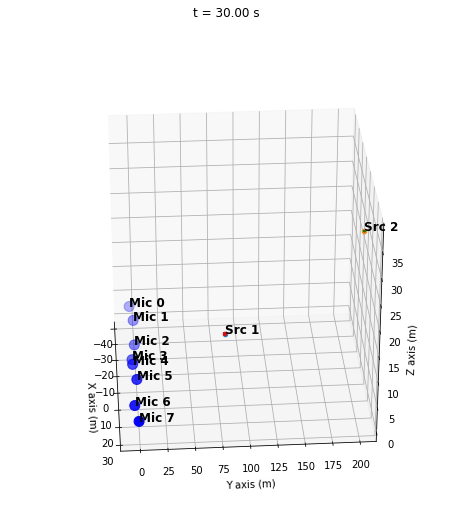

In [79]:
_,_,_,_,tInc = hSpecs[0][0]
colors = 'rgymc'
colIdx = 0
mu = 1e3
images = []
durations = [] # ms
for segIdx in range(30,31):
    # draw pic frame
    fig = plt.figure(figsize=(8,8))
    axes = fig.gca(projection='3d')
    #axes.set_aspect("equal")
    #print(np.shape(grps[segIdx]))
    
    srcCnt = 0
    while True:
        # generate output for each channel
        # find the most overlapped set of groups
        seq = audio_loc.bestLink(grps[segIdx])
        #print(seq)
        if len(seq) == 0:
            break
        '''
        plt.figure(figsize=(10,15))
        for chIdx in range(NCh):
            plt.subplot(NCh,1,chIdx+1)
            plt.pcolormesh(grps[segIdx,chIdx][seq[chIdx]])
        '''

        #print('==========')
        srcCnt += 1
        # form the measurement matrix, i.e.
        # measure the delays in matrix form
        meas_delayMat = np.zeros((NCh,NCh))
        for k in range(NCh):
            for l in range(k+1,NCh):
                corr = audio_loc.gramCorr(grps[segIdx,k][seq[k]],grps[segIdx,l][seq[l]],NInc=100)
                '''
                print(np.argmax(corr))
                plt.figure()
                plt.plot(corr)
                '''
                meas_delayMat[k,l] = tInc*(np.argmax(corr)-len(corr)//2)
                meas_delayMat[l,k] = -meas_delayMat[k,l]
        #print(meas_delayMat)
        
        # localize the source from the given delay measurement
        #print('meas_delayMat = %s' % meas_delayMat)
        loc,err,grad = delay2loc.delay2loc_grad(micsloc,meas_delayMat,mu=mu,debug=True)
        #print('loc = %s, grad = %s' % (loc,grad))
        axes.scatter(loc[0],loc[1],loc[2])
        axes.text(loc[0],loc[1],loc[2],'Src %d' % srcCnt,fontweight='bold',fontsize='large')
        draw_ball(axes,loc,mu*grad,color=colors[colIdx%len(colors)])
        colIdx += 1
        
        # remove the connected groups
        audio_loc.rmGrp(grps[segIdx],seq)
        '''
        # sanity check of grps
        for chIdx in range(NCh):
            print(np.shape(grps[segIdx,chIdx]))
        '''

    axes.scatter(micsloc[:,0],micsloc[:,1],micsloc[:,2],s=100,c='b')
    for k in range(NCh):
        axes.text(micsloc[k,0],micsloc[k,1],micsloc[k,2],'Mic %s' % k,
                  fontweight='bold',fontsize='large')

    axes.set_xlabel('X axis (m)')
    #axes.set_xlim([-50,30])
    axes.set_ylabel('Y axis (m)')
    #axes.set_ylim([-5,10])
    axes.set_zlabel('Z axis (m)')
    #axes.set_zlim([0,10])
    
    fig.suptitle('t = %.2f s' % (segIdx*tSegInc))

    # draw with rotating azimuth angle
    for angle in range(0,360,4):
        axes.view_init(30, angle)
        imData = fig2data(fig)
        w,h,d = imData.shape
        im = PIL_Image.frombytes('RGBA',(w,h),imData)
        images.append(im)
        durations.append(100)

In [80]:
delays,_ = delay2loc.estDelay(micsloc,loc)
delayMat = delay2loc.toMat(delays)
err = 0.5*np.sum(np.abs(delayMat-meas_delayMat))
print('delayMat = \n%s' % delayMat)
print('meas_delayMat =\n%s' % meas_delayMat)
print('err = %s' % err)

delayMat = 
[[ 0.         -0.01639754 -0.0222667  -0.0194341  -0.02512048 -0.03737201
  -0.02979968 -0.03972424]
 [ 0.01639754  0.         -0.00586916 -0.00303656 -0.00872294 -0.02097446
  -0.01340214 -0.0233267 ]
 [ 0.0222667   0.00586916  0.          0.0028326  -0.00285378 -0.0151053
  -0.00753298 -0.01745754]
 [ 0.0194341   0.00303656 -0.0028326   0.         -0.00568638 -0.01793791
  -0.01036558 -0.02029014]
 [ 0.02512048  0.00872294  0.00285378  0.00568638  0.         -0.01225153
  -0.0046792  -0.01460376]
 [ 0.03737201  0.02097446  0.0151053   0.01793791  0.01225153  0.
   0.00757232 -0.00235224]
 [ 0.02979968  0.01340214  0.00753298  0.01036558  0.0046792  -0.00757232
   0.         -0.00992456]
 [ 0.03972424  0.0233267   0.01745754  0.02029014  0.01460376  0.00235224
   0.00992456  0.        ]]
meas_delayMat =
[[ 0.         -0.00870748 -0.01160998 -0.01160998 -0.00870748 -0.02031746
  -0.02031746 -0.02031746]
 [ 0.00870748  0.         -0.01451247 -0.01160998 -0.00870748 -0.020317

[autoreload of delay2loc failed: Traceback (most recent call last):
  File "/home/blissbox/env3.6/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/blissbox/env3.6/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/blissbox/env3.6/lib/python3.6/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/blissbox/env3.6/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 608, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 205, in _call_with_frames_removed
  File "/home/blissbox/audio_loc/pyth

In [ ]:
# sanity checks
size = fig.get_size_inches()*fig.dpi # size in pixels
size = tuple(size.astype(int))
print(size)
#print('(%s, %s)' % (w,h))
print(size == (w,h))

print(images[0])
plt.figure(figsize=(8,16))
plt.subplot(211)
plt.imshow(images[0])
plt.subplot(212)
plt.imshow(images[1])

In [46]:
# Animate
gif_pathname = 'images/micsloc_srcloc.gif'
gif = images[0]
#gif.info['duration'] = tuple([100]*len(images)) # ms per frame
gif.info['duration'] = tuple(durations)
gif.info['loop'] = 0 # how many times to loop (0=infinite)
gif.save(fp=gif_pathname, format='gif', save_all=True, append_images=images[1:])

# verify that the number of frames in the gif equals the number of image files and durations
print(len(images))
print(PIL_Image.open(gif_pathname).n_frames == len(images))

# might need to refresh the page to reload the image,
# according to https://github.com/jupyter/notebook/issues/1369
Image(url=gif_pathname)

90
True


In [ ]:
########## Work on all recordings
'''
for file in os.listdir(DATAROOT):
    print(file)
    fs,data = audio_class.readSegment(DATAROOT+file)
    break
'''